In [1]:
import numpy as np
import torch

from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from os import listdir
from PIL import Image

In [2]:
IMAGE_PATH = '../data/images'
NUMBER_OF_IMAGES = 20000
LABEL_PATH = '../data/annotations'
NUMBER_OF_CLASSES = 14

In [3]:
def get_class_map():
    classnametoint = {}
    inttoclassname = {}

    i = 0
    label_files = sorted(listdir(LABEL_PATH))
    for fname in label_files:
        img_class, _ = fname.split('.')
        classnametoint[img_class] = i
        inttoclassname[i] = img_class
        i += 1

    return classnametoint, inttoclassname

In [23]:
# Parameters:
#   bs: batch size (default 64)
#   samples_to_print: number of samples to print when getting dataloader (default 0)

def get_dataloader(bs=64, samples_to_print=0):
    data = []
    # 2d array where each row is an image and each column is a boolean indicating if label is active. 
    # Row number is image number. Row 0 will not be used since there is no image number 0.
    class_array = np.zeros((NUMBER_OF_IMAGES + 1, NUMBER_OF_CLASSES), dtype=bool)
                
    # mapping from class names to integers
    class_map, class_int_to_string = get_class_map()

    # loop through all the annotations
    label_files = sorted(listdir(LABEL_PATH))
    for fname in label_files:
        img_class, _ = fname.split('.')
        class_int = class_map[img_class]
        
        # open the annotation
        with open(f'{LABEL_PATH}/{fname}', 'r') as fh:

            # get image ids from annotation file
            img_ids = fh.read().splitlines()
            
            # For the image, set the bool corresponding to the class to True
            for im_id in img_ids:
                class_array[int(im_id)][class_int] = True
    
    # Now we have a complete array of image labels in class_array
    #print(class_array[0:20,])
    
    # Let's iterate through the images and attach the labels vector to each image
    nblackwhite = 0
    nsinglechannel = 0 
    ntwochannel = 0
    nfourormorechannels = 0
    skippedids = []
    for img_id in range(1, NUMBER_OF_IMAGES + 1):
        img_path = f'{IMAGE_PATH}/im{img_id}.jpg'
        img = Image.open(img_path)
        #img_grayscale = img.convert("L") 
        img_rgb = img.convert("RGB")
        
        img_data = np.asarray(img_rgb)
        
        # skip black-and-white images
        imshape = img_data.shape
        if not len(imshape) == 3:
            if len(imshape) == 1:
                nsinglechannel += 1
            elif len(imshape) == 2:
                ntwochannel += 1
            elif len(imshape) > 3:
                nfourormorechannels += 1
            nblackwhite += 1
            skippedids.append(img_id)
            continue

        img_data = img_data.flatten().astype(np.float32)

        data.append([img_data, class_array[img_id].astype(np.float32)])

    print(f'Skipped {nblackwhite} images that were black and white.')
    print(f'   of which {nsinglechannel} images had one channel.')
    print(f'   of which {ntwochannel} images had two channels.')
    print(f'   of which {nfourormorechannels} images had 4 or more channels.')
    
    # Print some samples of the data items if samples_to_print is set
    if (samples_to_print > 0):
        print(f'\nFirst {samples_to_print} data items and their labels:')
        for i in range(samples_to_print):
            print(f'\nImage number {i+1}')
            print(data[i])
            print('   Labels in text:')
            print('      ', end = ' ')
            for lab in range(NUMBER_OF_CLASSES):
                if(data[i][1][lab]):
                    print(class_int_to_string[lab], end = ' ')
            print('')
        
    return DataLoader(data, batch_size=bs, shuffle=True)

In [5]:
class TwoLayerModel(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_classes):
        super().__init__()

        self.input_layer = nn.Linear(n_input, n_hidden1)
        self.hidden1 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden2 = nn.Linear(n_hidden2, n_classes)
        self.relu = nn.ReLU()
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        #x = self.softmax(x)

        return x

In [6]:
def train(dataloader, model, optimizer, criterion, device, n_epochs=50, losses=[]):

    model.train()

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(dataloader):
            X, y = batch
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step
            
            losses.append(loss)

        print(f'Epoch: {epoch}, loss: {loss}')

In [18]:
# Visualize some samples 

def visualize_samples(ntoshow=3):
    _, class_int_to_string = get_class_map()

    # Get a batch of training data
    inputs, classes = next(iter(dataloader))
    
    inputs = inputs.numpy().reshape((inputs.shape[0], 128, 128, 3)).astype(np.uint8)

    for i in range(ntoshow):
        plt.imshow(inputs[i])
        imagelabels = []
        for lab in range(NUMBER_OF_CLASSES):
            if(classes[i][lab]):
                imagelabels.append(class_int_to_string[lab])
        plt.title(imagelabels)
        plt.pause(0.001)

In [27]:
use_cuda = True

device = torch.device('cuda') if use_cuda else torch.device('cpu')

lr = 0.05
n_epochs = 5
bs = 256
class_map, _ = get_class_map()
n_classes = len(class_map.keys())

model = TwoLayerModel(128*128*3, 1024, 512, n_classes).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [24]:
dataloader = get_dataloader(bs, samples_to_print=1)

Skipped 0 images that were black and white.
   of which 0 images had one channel.
   of which 0 images had two channels.
   of which 0 images had 4 or more channels.

First 1 data items and their labels:

Image number 1
[array([201., 196., 177., ...,   8.,  13.,   6.], dtype=float32), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.],
      dtype=float32)]
   Labels in text:
       female people portrait 


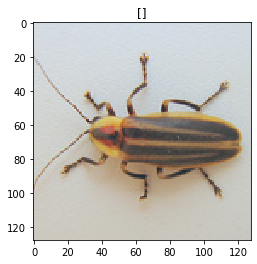

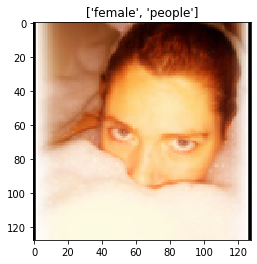

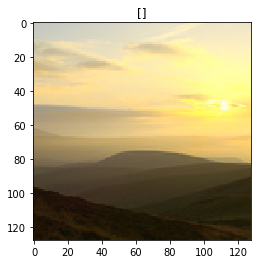

In [25]:
visualize_samples()

In [28]:
train(dataloader, model, optimizer, criterion, device, n_epochs)

Epoch: 0, loss: 7.45031213760376
Epoch: 1, loss: 7.638508319854736
Epoch: 2, loss: 7.491977691650391
Epoch: 3, loss: 7.767365455627441
Epoch: 4, loss: 8.635235786437988
